In [1]:
import matplotlib
import matplotlib.pyplot as plt
%matplotlib inline

import numpy as np
import pandas as pd
import rasterio

In [3]:


# img_in = io.imread(os.path.join(path,image_file), plugin='tifffile')


# Use this for reading in all images in a file
# x_train_full = []
# path = "../data/images/downloads/split256"
# for path, dirname, files in os.walk(path):
#     for file in files:
#         if file.endswith(".tif"):
#             img_in = io.imread(os.path.join(path,file))
#             print(type(img_in[0][0][0]))
#             x_train_full.append(img_in)

# x_train_full = np.array(x_train_full, np.float32)

 NOTE: PlanetScope 4-band images, the band order is BGRN: (1) Blue, (2) Green, (3) Red, (4) Near-infrared

In [ ]:
# Read in a single image and then process it 
from xml.dom import minidom


path = "../data/raw_images/Cairo_20170828_085947_0f3b"
image_file = "20170828_085947_0f3b_3B_AnalyticMS.tif"

with rasterio.open(os.path.join(path,image_file)) as src:
    bands = src.read()
print(bands.shape)

# Change dimensions
bands = np.rollaxis(bands, 0, 3)
print(bands.shape)

# Check max pixel value
print(np.amax(bands))

# Get the reflectance coefficient
xml_file = "20170828_085947_0f3b_3B_AnalyticMS_metadata.xml"
xmldoc = minidom.parse(os.path.join(path, xml_file))
nodes = xmldoc.getElementsByTagName("ps:bandSpecificMetadata")

# XML parser refers to bands by numbers 1-4
coeffs = {}
for node in nodes:
    bn = node.getElementsByTagName("ps:bandNumber")[0].firstChild.data
    if bn in ['1', '2', '3', '4']:
        i = int(bn)
        value = node.getElementsByTagName("ps:reflectanceCoefficient")[0].firstChild.data
        coeffs[i] = float(value)


0.4943365489711365


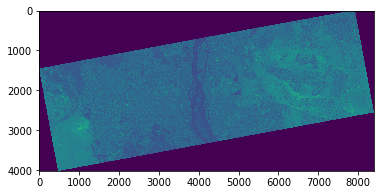

In [112]:
# Normalize bands by multiplying by the respective coefficient
print(new_bands.shape)
new_bands = np.zeros(bands.shape)

num_bands = bands.shape[-1]
for i in range(num_bands):
    new_bands[:, :, i] = bands[:, :, i] * coeffs[i+1]
    
print(np.amax(new_bands))
plt.imshow(new_bands[:, :, 0])

In [ ]:
green_band = bands[:, :, 1] * coeffs[2]
print(np.amax(green_band))
plt.imshow(green_band[:, :])

0.2965147351947915
(2, 256, 256, 4)


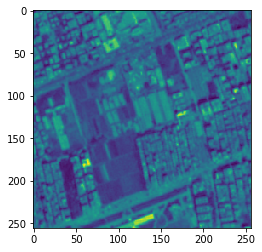

In [123]:
# Create 2 images of size (256, 256) from the larger image to test out

test_img_1 = new_bands[2000:2256, 2000:2256, :]
test_img_2 = new_bands[2100:2356, 2100:2356, :]
test_imgs = [test_img_1, test_img_2]
smaller_bands = np.array(test_imgs)
print(np.amax(smaller_bands))
print(smaller_bands.shape)
plt.imshow(smaller_bands[1,:, :, 0])
plt.show()
X_train = smaller_bands

In [4]:
# from sklearn.model_selection import train_test_split
# X_train, X_test = train_test_split(x_train_full, test_size=0.20, random_state=42)

# print(X_train.shape)
# print(X_test.shape)

(299, 256, 256, 4)
(75, 256, 256, 4)


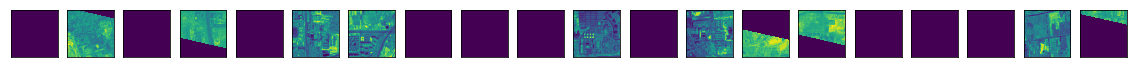

In [9]:
# n = 20
# plt.figure(figsize=(20, 2))
# for i in range(1,n+1):
#     ax = plt.subplot(1, n, i)
#     plt.imshow(X_train[i][:, :, 3])
#     ax.get_xaxis().set_visible(False)
#     ax.get_yaxis().set_visible(False)

In [127]:
# Autoencoder
from keras.layers import Input, Dense, Conv2D, MaxPooling2D, UpSampling2D
from keras.models import Model
from keras import backend as K

input_img = Input(shape=(256, 256, 4))  

x = Conv2D(128, (3, 3), activation='relu', padding='same')(input_img)
x = MaxPooling2D((2, 2), padding='same')(x)
x = Conv2D(64, (3, 3), activation='relu', padding='same')(x)
encoded = MaxPooling2D((2, 2), padding='same')(x)

# Need to get encoding output here

x = Conv2D(64, (3, 3), activation='relu', padding='same')(encoded)
x = UpSampling2D((2, 2))(x)
x = Conv2D(128, (3, 3), activation='relu', padding='same')(x)
x = UpSampling2D((2, 2))(x)
decoded = Conv2D(4, (3, 3), activation='sigmoid', padding='same')(x)

autoencoder = Model(inputs=input_img, 
                    outputs=[decoded])

encoder = Model(inputs=input_img,
                outputs=encoded)

autoencoder.compile(optimizer='adam', 
                    loss='binary_crossentropy', 
                    metrics=['accuracy'])

In [128]:
autoencoder.fit(X_train, X_train,
                epochs=20,
                batch_size=32,
                shuffle=True,
                validation_data=(X_train, X_train), 
                verbose=True)

Train on 2 samples, validate on 2 samples
Epoch 1/20
2/2 [==============================] - 0s 194ms/step - loss: 0.6915 - acc: 0.6256 - val_loss: 0.6806 - val_acc: 0.7500
Epoch 2/20
2/2 [==============================] - 0s 70ms/step - loss: 0.6806 - acc: 0.7500 - val_loss: 0.6572 - val_acc: 0.7500
Epoch 3/20
2/2 [==============================] - 0s 65ms/step - loss: 0.6572 - acc: 0.7500 - val_loss: 0.6155 - val_acc: 0.7500
Epoch 4/20
2/2 [==============================] - 0s 62ms/step - loss: 0.6155 - acc: 0.7500 - val_loss: 0.5467 - val_acc: 0.7500
Epoch 5/20
2/2 [==============================] - 0s 59ms/step - loss: 0.5467 - acc: 0.7500 - val_loss: 0.4464 - val_acc: 0.7500
Epoch 6/20
2/2 [==============================] - 0s 57ms/step - loss: 0.4464 - acc: 0.7500 - val_loss: 0.3220 - val_acc: 0.7500
Epoch 7/20
2/2 [==============================] - 0s 56ms/step - loss: 0.3220 - acc: 0.7500 - val_loss: 0.2068 - val_acc: 0.7500
Epoch 8/20
2/2 [==============================] - 0s 5

In [19]:
# Attempt at K-means
import cv2
# define criteria and apply kmeans()
criteria = (cv2.TERM_CRITERIA_EPS + cv2.TERM_CRITERIA_MAX_ITER, 10, 1.0)
ret,label,center=cv2.kmeans(x_train,2,None,criteria,10,cv2.KMEANS_RANDOM_CENTERS)

# Now separate the data, Note the flatten()
A = Z[label.ravel()==0]
B = Z[label.ravel()==1]

# Plot the data
plt.scatter(A[:,0],A[:,1])
plt.scatter(B[:,0],B[:,1],c = 'r')
plt.scatter(center[:,0],center[:,1],s = 80,c = 'y', marker = 's')
plt.xlabel('Height'),plt.ylabel('Weight')
plt.show()

error: /io/opencv/modules/core/src/kmeans.cpp:243: error: (-215) data0.dims <= 2 && type == 5 && K > 0 in function kmeans
